## Does Increased Population Size Benefit HIGA/EIGA/RIGA?

In [9]:
import time 
import random
import numpy as np
import itertools
import networkx as nx
from statistics import mean
import matplotlib.pyplot as plt
import heapq

**Graph Generation**

In [1]:
# Generate coordinates for n nodes 
# n: Number of nodes 
# scale: Scaling factor for coordinates generated between [0, 1)
def generate_nodes(n, scale):
    return np.random.rand(n, 2) * scale

# Calculate the straight line distance between coordinates  
#     by applying Pythagoras' theorem (a^2 + b^2 = c^2)
# a: First coordinate pair 
# b: Second coordinate pair 
def pythag(a, b):
    return np.sqrt(np.square(a[0] - b[0]) + np.square(a[1] - b[1]))

def depth_factor(i, j):
    return np.exp(-pythag(i, j))

def surface_factor(si, sj):
    return (si + sj)

def nx_log_normal(size, degree):
    # Generate coordinates in range [0, 1]
    scale = 1
    nodes = generate_nodes(size, scale)
    
    # Define surface weights for each node 
    surfaces = np.random.lognormal(mean = 0.0, sigma = 1.0, size = size)
    
    # Define the surface factor between every node pair 
    # Larger surfaces have greater probability to connect 
    sf = [[surface_factor(i, j) for i in surfaces] for j in surfaces] 
    
    # Define the depth factor between every pair of nodes 
    # Geometrically closer nodes have higher depth factor 
    df = [[depth_factor(i, j) for i in nodes] for j in nodes]
    
    # Calculate the existence probability for each edge 
    # depth_factor_ij * surface_factor_ij 
    ep = np.multiply(df, sf)
    total_ep = np.sum(ep)
    
    # Roulette wheel 
    # Create an edge (i, j) with Pr. proportional to ep_ij 
    edges_set = []
    
    while degree > 0:
        pr_sum = 0.0 
        ptr = random.random()
        
        for i, j in itertools.product(range(size), range(size)):
                if i == j:
                    continue 
                
                pr = ep[i][j] / total_ep
                pr_sum += pr 
                
                if pr_sum > ptr: 
                    edges_set.append((i, j, {'weight': pr}))
                    break
        
        degree = degree - 1 
    
    G = nx.Graph()
    G.add_nodes_from(range(size))
    G.add_edges_from(edges_set)
    
    return G 

def nx_connected_ln(size, degree):
    # Set a hard limit on the number of models generated
    # before exit
    max_iterations = 1000 
    
    # Generate models until connected
    for i in range(max_iterations):
        G = nx_log_normal(size, degree)
        
        # Check if G is connected 
        connected = True
        for node in range(size):
            if G.degree[node] == 0:
                connected = False
    
        if connected:
            return (connected, G)
    
    # Return the false flag and null model
    return (False, None)

In [2]:
def erdos_renyi(n, p):
    # Create an empty networkx graph
    G = nx.Graph()
    
    # Add n nodes
    G.add_nodes_from(range(n))
    
    # Add possible edges with probability p
    # Disallow self-edges
    for i in range(n):
        for j in range(n):
            if i == j:
                continue 
            
            rnd = random.random()
            
            if rnd < p:
                G.add_edge(i, j)
    
    return G

def connected_erdos_renyi(n, p):
    for i in range(100):
        G = erdos_renyi(n, p)
        
        # Check if connected
        connected = True
        for node in range(n):
            if G.degree[node] == 0:
                connected = False
        
        if connected:
            return G
    
    print("Failed to create connected ER")
    return None 

In [3]:
# Randomly assign edge weights in range to graph
def assign_random_weights(G, wmin, wmax, w = None):
    if w is None:
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = np.random.uniform(low=wmin, high=wmax)
    else:
        for edge in G.edges():
            G[edge[0]][edge[1]]['weight'] = w

**Standard GA**

In [4]:
def path_length(p, g):
    return sum(g[i][j]['weight'] for i, j in zip(p, p[1:]))

def fit(p, g):
    return path_length(p, g) ** (-1)

# Function to define a single new random path from node s to node r
# in a network supplied as a Networkx graph 
# G: Graph / network as networkx
# s: Start node 
# r: Destination node 
def gen_path(G, s, r):
    path = [s]
    
    current = s
    while current != r: 
        # Neighbours exluding nodes in path 
        neighbours = [n for n in G[current] if n not in path]
        
        # Sometimes, neighbours is empty 
        # In which case, retry 
        if not neighbours:
            return gen_path(G, s, r)
        
        # Select neighbour node with uniform probability  
        nxt = np.random.choice(neighbours) 
        
        # List and visit next node 
        path.append(nxt)
        current = nxt 
        
    return path

# Function to generate a population of n random paths s->r
# G: Graph as networkx
# s: Start node
# r: Destination node
# n: Number of paths / size of population 
def gen_population(G, s, r, n):
    population = [] 
    for i in range(n):
        # Generate a new candidate path
        candidate = gen_path(G, s, r)
        # Generate a new candidate 
        population.append(candidate)
    
    return population

# Perform crossover between two paths s->r
# The two paths must have at least one common element 
# From the set of common elements, one is selected, v 
# The paths are redifined as s -> v, v -> r  
# The path segments are recombined to create two children
# a: The first path
# b: The second path 
def crossover(a, b):
    common = [] 
    for ind_a, i in enumerate(a):
        for ind_b, j in enumerate(b):
            if i == j:
                common.append((ind_a, ind_b))
    
    # Randomly select a one common element to exchange
    target = np.random.choice(len(common))
    
    # Retrieve indexes
    ind_a, ind_b = common[target]
    
    # Create new arrays
    chd_a = a[:ind_a] + b[ind_b:]
    chd_b = b[:ind_b] + a[ind_a:]
    
    return chd_a, chd_b

def mutate(G, path):
    # Select a random element in path, v
    ind = np.random.choice(len(path) - 1)
    
    # Create a new random path from v to destination 
    v = path[ind]
    rnd_path = gen_path(G, v, path[-1])
    
    return path[:ind] + rnd_path

# Compute the fitness value of each hypotheses 
# p: Population
# g: Graph 
# Return: fitness list, maximum fitness value, sum of fitness values 
def evaluate(p, g):
    # Evaluate the fitness of the population 
    fitness = [fit(h, g) for h in p]

    return fitness, max(fitness), sum(fitness), mean(fitness)

# Stochastic universal selection 
#     - Uses a single random value to sample all solutions 
# n: Number of hypotheses to select
# population: Population of hypotheses
# fitness: Fitness array
# ftotal: Sum of fitness values 
# target: Target array to append selected hypotheses 
def stochastic_universal(n, population, fitness, ftotal, target):
    step = ftotal / n                       # Size of selection bins 
    start = random.uniform(0, step)     # Random in range [0, step)
    
    # Each pointer value indicates a selection threshold
    # When the sum of probabilities exceeds a pointer, the current hypotheses is selected 
    pointers = [(start + (i * step)) for i in range(0, n)]
    
    for ptr in pointers:
        ind = 0               # Current index 
        running_sum = 0.0       # Sum of probabilities (fit(h) / total_fitness)
        
        # Until the threshold is exceeded 
        while running_sum < ptr: 
            running_sum += fitness[ind]
            ind += 1 
        
        target.append(population[ind - 1])

In [5]:
# threshold: Number of iterations with unchanged best fitness before exit 
# itr: Maximum number of iterations before quit 
# p: size of population 
# r: fraction of population to be replaced by crossover 
# m: mutation rate 
# ri: Proportion of new population to replace with random immigrants
# ei: Proportion of new population to replace with elitist immigrants 
# im: Probability to mutate elite candidate in immigrant generation 
# s: start node in path 
# d: destination node in path
# G: graph 
def higa(G, threshold, itr, p, r, m, ri, ei, im, src, dst):
    # Store the history of max and mean fitness for generations 
    history = []
    
    # Take starting time 
    start = time.time()
    
    # Generate a random population 
    # Graph; start node; dest node; size of population 
    population = gen_population(G, src, dst, p) 
    fitness, fmax, ftotal, favg = evaluate(population, G)
    
    # Previous generation elite 
    prev_elite = population[np.argmax(fitness)]
    
    # Generations 
    count = 0
    unchanged = 0 
    while  (unchanged < threshold) and (count < itr):  
        # Append to training history 
        history.append((fmax, favg, ftotal))
        
        # Create new generation 
        gen = []
        
        # Select ((1 - r) * p) hypotheses to persist into the next generation
        # Hypotheses are selected with fitness proportional probability 
        # Pr(hi) = fit(hi) / sumj(fit(hj))
        num_hypotheses = int((1 - r) * p)
        stochastic_universal(num_hypotheses, population, fitness, ftotal, gen)
        
        # Select (r * p) / 2 pairs of parents for crossover 
        # Parent hypotheses are chosen with fitness proportional probability 
        # Pr(hi) = fit(hi) / sumj(fit(hj))
        parents = [] 
        num_parents = int(r * p) 
        stochastic_universal(num_parents, population, fitness, ftotal, parents)
        
        # Crossover pairs of parents 
        pairs = zip(parents, parents[1:])  # Zip into pairs [1, 2, 3] -> (1, 2), (2, 3)
        for a, b in pairs:
            e, f = crossover(a, b)   # Crossover parents a,b to get children c,d 
            gen.append(e) 
            gen.append(f)
        
        # Choose m percent of new population uniformly to mutate 
        m_size = int(m * p)
        for i in np.random.choice(len(gen), m_size):
            gen[i] = mutate(G, gen[i]) 
        
        # *** BEGIN HI SCHEME ***
        
        # Evaluate interim population 'gen'
        (gf, gmax, gtotal, gavg) = evaluate(gen, G)
        
        # Calculate number of immigrants
        n_ri = int(ri * p)
        n_ei = int(ei * p)
        n_immigrants = n_ri + n_ei 
        
        # Generate ri*p random immigrants 
        immigrants = gen_population(G, src, dst, n_ri)
        
        # Generate ei*p elitist immigrants 
        for i in range(n_ei):
            # Mutate elite from p(t - 1)
            if random.random() < im:
                immigrants.append(mutate(G, prev_elite)) 
            else:
                immigrants.append(prev_elite)

        # Replace the ri*p worst candidates with immigrants 
        # O(n log k) to find k smallest elements in array of n 
        #   - Use min heap of size k, compare each element to heap min, i
        #        if smaller then remove max and replace 
        heap = []
        for i in range(n_immigrants):
            # Tuple (fitness, index) and order heap on first element
            heapq.heappush(heap, (-(gf[i]), i)) 
        heapq.heapify(heap)
        
        # Add smaller elements and maintian heap 
        for i in range(n_immigrants, len(gen)):
            if -(gf[i]) < heap[0][0]:
                heap[0] = heap[-1]
                heap.pop()
                heap.append( ((-gf[i]), i) )
                heapq.heapify(heap)
                
        # Replace worst candidates 
        for i in range(n_immigrants):
            ind = heap[i][1]
            gen[ind] = immigrants[i]
        
        # Set elite 
        # Elite is best of P(t - 1), 
        # Each generation G(t) works on P(t) to Generate P(t + 1)
        prev_elite = population[np.argmax(fitness)]
        
        # *** END of HI SCHEME *** 
        
        # Population equal to copy of generation 
        population = list(gen) 
        
        # Evaluate the new population fitness
        _fmax = fmax
        fitness, fmax, ftotal, favg = evaluate(population, G)
        
        # Check if maximum fitness solution has changed 
        if _fmax == fmax:
            unchanged += 1 
        else:
            unchanged = 0 # Reset when max fitness changes 
        
        # Increment generation count
        count += 1 
    
    # Return stats and performance 
    ind = np.argmax(fitness)
    runtime = time.time() - start 
    
    results = {"generations": count, "runtime": runtime,
               "learning_history": history, 
               "solution": population[ind], 
               "length": path_length(population[ind], G), 
               "fitness": fitness[ind]}
    
    return results 

**Test**

In [10]:
# GA Hyperparameters 
THRESHOLD = 100          # Iterations where maximum fitness is unchanged to exit
ITERATIONS = 20          # Maximum iterations 
M_RATE = 0.025           # Mutation rate (percent of population to mutate)
R_RATE = 0.5             # Percent of population to select as parents

RI = 0.1
EI = 0.1
IM = 0.8

# Create a large graph 
flag, G = nx_connected_ln(500, 3000)

# For ten separate src, dst pairs 
results_small = []
results_large = [] 
for i in range(10):
    
    src, dst = np.random.choice(500, size = 2, replace = False)
    
    # Small
    small = higa(G, THRESHOLD, ITERATIONS, 100, R_RATE, M_RATE, RI, EI, IM, src, dst)
    
    # Large
    large = higa(G, THRESHOLD, ITERATIONS, 120, R_RATE, M_RATE, RI, EI, IM, src, dst)
    
    
    results_small.append([x for x,y,z in small["learning_history"]])
    results_large.append([x for x,y,z in large["learning_history"]])

x_small = np.mean(results_small, axis = 0)
x_large = np.mean(results_large, axis = 0)

**Plot Mean Fitmax History**

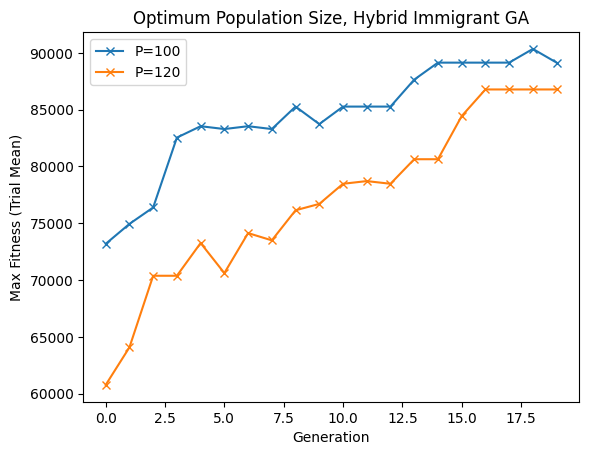

In [15]:
plt.figure()
plt.plot(x_small, marker = "x")
plt.plot(x_large, marker = "x")
plt.legend(("P=100", "P=120"), loc = "best")
plt.title("HIGA Fitness with Increased Population Size")
plt.xlabel("Generation")
plt.ylabel("Max Fitness (Trial Mean)")
plt.title("Optimum Population Size, Hybrid Immigrant GA")

plt.savefig("./plots/exp_2_HIGA_pop/population_size_test.jpg", dpi = 300)